In [212]:
import gensim.downloader as api
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

from collections import Counter
from gensim.models import KeyedVectors
from joblib import dump, load
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, Embedding, Flatten
from keras.models import Sequential
from keras.optimizers.legacy import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.regularizers import l2
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from scikeras.wrappers import KerasClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
word2vec_model = api.load("word2vec-google-news-300", return_path=True)
print(word2vec_model)

/Users/aaron.pradhan/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [3]:
# Load the actual model from the saved file path
model = KeyedVectors.load_word2vec_format(word2vec_model, binary=True)

In [4]:
with open("imdb/train/pos/0_9.txt") as f:
    print(f.read())

Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!


In [5]:
def read_files_from_directory(directory_path):
    file_contents = []
    for filename in os.listdir(directory_path):
        filepath = os.path.join(directory_path, filename)
        with open(filepath, 'r', encoding='utf-8') as file:
            file_contents.append(file.read())
    return file_contents

positive_train_samples = read_files_from_directory("imdb/train/pos/")
negative_train_samples = read_files_from_directory("imdb/train/neg/")
positive_test_samples = read_files_from_directory("imdb/test/pos/")
negative_test_samples = read_files_from_directory("imdb/test/neg/")

print(len(positive_train_samples))
print(len(negative_train_samples))
print(len(positive_test_samples))
print(len(negative_test_samples))

12500
12500
12500
12500


In [6]:
# Combine and label data
train_data = positive_train_samples + negative_train_samples
train_labels = [1] * len(positive_train_samples) + [0] * len(negative_train_samples)

test_data = positive_test_samples + negative_test_samples
test_labels = [1] * len(positive_test_samples) + [0] * len(negative_test_samples)

train_df = pd.DataFrame({'review': train_data, 'label': train_labels})
test_df = pd.DataFrame({'review': test_data, 'label': test_labels})

# Randomize order of samples
randomized_train_df = train_df.sample(frac=1).reset_index(drop=True)
randomized_test_df = test_df.sample(frac=1).reset_index(drop=True)

randomized_train_df

,review,label
0,This is the worst sequel on the face of the wo...,0
1,I really love this movie. I remember one time ...,1
2,I know the people and I did some of the animat...,0
3,A group of extremely unlikable A-holes are tor...,0
4,An excellent documentry. I personally remember...,1
...,...,...
24995,This series would have been a lot better if th...,0
24996,Whale-hunters pick on the wrong freaking whale...,0
24997,"This is a terrible movie, terrible script, bad...",0
24998,Sidney Young (Pegg) moves from England to New ...,1


In [7]:
randomized_test_df

,review,label
0,"An entertaining first draft for ""North By Nort...",1
1,"as a former TV editor, I can say this is as au...",1
2,A dull stroll through the banalities of Mormon...,0
3,"""Tenchi Muyo In Love 2"" is the third Tenchi mo...",0
4,"A blaxploitation classic, this movie was terri...",1
...,...,...
24995,I tuned in to this movie because there was not...,1
24996,"I am surprised that this, well above average 8...",1
24997,I do not think that this movie deserves the lo...,1
24998,Silly comedy casts an embarrassed-seeming Ray ...,0


In [8]:
# Get a sense of the review contents to determine what steps to include in preprocessing
for i in range(10):
    print(f"Review {i + 1}:")
    print(randomized_train_df["review"][i])
    print(f"{'=' * 20}")

Review 1:
This is the worst sequel on the face of the world of movies. Once again it doesn't make since. The killer still kills for fun. But this time he is killing people that are making a movie about what happened in the first movie. Which means that it is the stupidest movie ever.<br /><br />Don't watch this. If you value the one precious hour during this movie then don't watch it. You'll want to ask the director and the person beside you what made him make it. Because it just doesn't combine the original makes of horror, action, and crime.<br /><br />Don't let your children watch this. Teenager, young child or young adult, this movie has that sorta impact upon people.
Review 2:
I really love this movie. I remember one time when I was in 2nd >grade, my teacher showed it to us on a 16mm film reel. This movie, however, can be a little frightening for 2nd graders such as the scene where Bill murders Nancy and seeing Fagin's face for the first time on the screen. One of my relatives is 

In [9]:
# The dataset contains many instances of line breaks encoded as <br />. We search for other HTML tags.

# Regular expression to find other HTML tags (or things that look like HTML tags)
regex_pattern = r'<(?!br|BR)[A-Za-z]+'

# Filter the dataframe
filtered_df = randomized_train_df[randomized_train_df['review'].str.contains(regex_pattern, na=False)]

# Print the first 5 matching cells
for review in filtered_df['review'].head(5):
    print(review)
    print("-----")



Remember the chain-smoking channeler exposed on 60 Minutes a few years ago? This is her. Lots of folks reviewed this movie without checking the bona fides of the filmmakers. The producers have been using phony "word of mouth" promotions very successfully without disclosing the financial and philosophical underpinnings for this piece of marketing tripe. If you believe in channeling, reincarnation, new age dreck and day-old baloney, this film is for you. If you want a discussion of quantum physics or reality, look elsewhere. The purpose of this movie is to convince you that Ramtha isn't a wacko, so you'll give her a bunch of your money. If you can tiptoe through the Ramtha website without howling in disbelief, then maybe you'll think the bucks you dropped on this infomercial for insanity was well spent. <http://rogerebert.suntimes.com/apps/pbcs.dll/section?category=ANSWERMAN>
-----
> Contrary to most reviews I've read, I didn't feel this followed any of the other rock movies ("Spinal Tap

In [10]:
regex_pattern = r'<[A-Za-z]+'

# Function to find all matches of the pattern in a text
def find_matches(text):
    return re.findall(regex_pattern, text)

# Apply the function to each cell in the 'review' column and accumulate all matches
all_matches = randomized_train_df['review'].apply(find_matches).sum()

# Count the occurrences of each match
match_counts = Counter(all_matches)

# Get the top 10 most frequent matches
top_10_matches = match_counts.most_common(10)

# Display the top 10 matches and their counts
for match, count in top_10_matches:
    print(f"{match}: {count}")

<br: 101870
<i: 7
<http: 1
<sp: 1
<SPOILER: 1
<sigh: 1
<em: 1
<grin: 1
<hr: 1


In [11]:
X_train = randomized_train_df["review"]
y_train = randomized_train_df["label"]
X_test = randomized_test_df["review"]
y_test = randomized_test_df["label"]

In [12]:
# Text Cleaning and Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


def preprocess(text):
    # Remove break tags
    text = re.sub(r'<br />', ' ', text)

    # Convert to lowercase and remove special characters
    text = re.sub(r'[^\w\s]', '', text.lower())

    # Tokenize
    words = text.split()

    # Remove stop words and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    return words

In [13]:
def document_vector(doc):
    # Remove out-of-vocabulary words
    doc = [word for word in doc if word in model.key_to_index]
    if len(doc) == 0:
        # Embedding has 300 features
        return np.zeros(model.vector_size)  # Return zero vector if doc is empty
    # Take the mean of the embeddings to get the vector for the whole document
    return np.mean(model[doc], axis=0)

In [14]:
# Apply preprocessing and vectorization
X_train_vec = np.array([document_vector(preprocess(text)) for text in X_train])
X_test_vec = np.array([document_vector(preprocess(text)) for text in X_test])

In [15]:
print(X_train_vec.shape)
print(X_test_vec.shape)

(25000, 300)
(25000, 300)


In [16]:
X_train_vec[:5]

array([[ 0.06935374, -0.01579895,  0.0732844 , ..., -0.05207858,
         0.03828812, -0.02302768],
       [ 0.06593085,  0.02957492,  0.02118463, ..., -0.04043037,
         0.05446887, -0.00979106],
       [ 0.01306367,  0.02822234,  0.01716507, ..., -0.09770712,
         0.00121267, -0.01929902],
       [ 0.04928667,  0.01618615, -0.03886639, ..., -0.0303572 ,
        -0.0096462 ,  0.01746614],
       [ 0.02450339,  0.03056502, -0.0060791 , ..., -0.04842585,
         0.0122714 , -0.04327157]], dtype=float32)

In [83]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_vec, y_train)

LogisticRegression(max_iter=1000)

In [119]:
# Cross-Validation
# Split the dataset into k=5 folds
# Train the model on k-1 folds, evaluate on the remaining fold
# Print accuracy for each model
lr_scores = cross_val_score(lr_model, X_train_vec, y_train, cv=5)
print("Cross-validation scores:", lr_scores)

Cross-validation scores: [0.851  0.8492 0.8492 0.8548 0.8554]


In [120]:
print(f"Mean cross-validation score: {np.mean(lr_scores)}")

Mean cross-validation score: 0.85192


In [ ]:
# Support Vector Machine (SVM)

In [86]:
# Start with linear kernel
# Took about 1 minute to train
svc_clf = svm.SVC(kernel="linear")
svc_clf.fit(X_train_vec, y_train)

SVC(kernel='linear')

In [121]:
# Cross validation, k=5
lin_svm_scores = cross_val_score(svc_clf, X_train_vec, y_train, cv=5)
print("Cross-validated scores:", lin_svm_scores)

Cross-validated scores: [0.8574 0.8528 0.854  0.8578 0.8574]


In [122]:
print(f"Mean cross-validation score: {np.mean(lin_svm_scores)}")

Mean cross-validation score: 0.85588


In [92]:
# Radial Basis Function (RBF) kernel
svc_clf_rbf = svm.SVC(kernel="rbf")
svc_clf_rbf.fit(X_train_vec, y_train)

SVC()

In [123]:
# Cross validation, k=5
rbf_svm_scores = cross_val_score(svc_clf_rbf, X_train_vec, y_train, cv=5)
print("Cross-validated scores:", rbf_svm_scores)
print(f"Mean RBF cross-validation score: {np.mean(rbf_svm_scores)}")

Cross-validated scores: [0.8598 0.8552 0.863  0.8618 0.865 ]
Mean RBF cross-validation score: 0.8609600000000001


In [145]:
np.std(rbf_svm_scores)

0.0033380233672040205

In [98]:
# Define parameter range
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1]}

In [101]:
grid = GridSearchCV(svm.SVC(), param_grid, refit=True, verbose=2, cv=5)

# Fit the model for grid search
grid.fit(X_train_vec, y_train)

# Print best parameters after tuning
print(grid.best_params_)

# Print how the model looks after hyperparameter tuning
print(grid.best_estimator_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .................................C=0.1, gamma=0.001; total time= 1.4min
[CV] END .................................C=0.1, gamma=0.001; total time= 1.4min
[CV] END .................................C=0.1, gamma=0.001; total time= 1.4min
[CV] END .................................C=0.1, gamma=0.001; total time= 1.4min
[CV] END .................................C=0.1, gamma=0.001; total time= 1.4min
[CV] END ..................................C=0.1, gamma=0.01; total time= 1.4min
[CV] END ..................................C=0.1, gamma=0.01; total time= 1.5min
[CV] END ..................................C=0.1, gamma=0.01; total time= 1.4min
[CV] END ..................................C=0.1, gamma=0.01; total time= 1.4min
[CV] END ..................................C=0.1, gamma=0.01; total time= 1.4min
[CV] END ...................................C=0.1, gamma=0.1; total time= 1.2min
[CV] END ...................................C=0.

In [111]:
grid.cv_results_

{'mean_fit_time': array([ 63.46735816,  65.5302618 ,  57.41900935,  39.1670588 ,
         68.05865197,  58.35992975,  39.76411963,  30.87440023,
         62.02959146,  43.32176394,  32.80828543,  40.10270529,
         43.31883173,  33.24280982,  38.68418765, 185.4409018 ]),
 'std_fit_time': array([1.1421681 , 0.81957408, 1.44142173, 0.23654866, 0.32943469,
        0.67789444, 0.4712991 , 0.40528053, 2.13731863, 0.46433234,
        0.50253901, 0.11977112, 0.54106606, 0.23235923, 0.45256309,
        4.34750743]),
 'mean_score_time': array([20.25500655, 20.16278977, 16.78707986, 11.42109904, 20.43861098,
        16.74930348, 11.0144299 ,  8.39286118, 17.04465804, 11.30286083,
         8.49376445,  7.86372519, 11.31736097,  8.44047112,  7.58199143,
         8.32481971]),
 'std_score_time': array([0.05531983, 0.05949274, 0.05968471, 0.05371619, 0.08174328,
        0.04021726, 0.02844337, 0.03477141, 0.17196771, 0.03615899,
        0.07579884, 0.0452167 , 0.02039161, 0.03949897, 0.06396533,


In [112]:
grid.cv_results_["mean_test_score"]

array([0.77032, 0.77024, 0.81312, 0.84644, 0.77032, 0.81296, 0.84692,
       0.85928, 0.81284, 0.8466 , 0.85632, 0.86456, 0.8468 , 0.85668,
       0.85848, 0.85428])

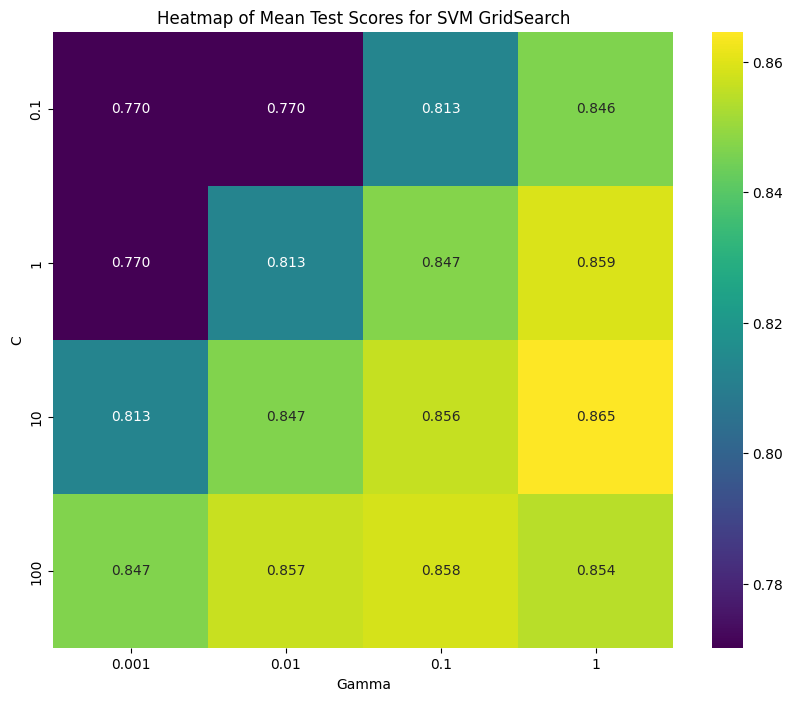

In [118]:
# Extract the scores into a matrix format
C_values = [0.1, 1, 10, 100]
gamma_values = [0.001, 0.01, 0.1, 1]
svm_cv_scores = grid.cv_results_['mean_test_score'].reshape(len(C_values), len(gamma_values))

# Plot scores
plt.figure(figsize=(10, 8))
sns.heatmap(svm_cv_scores, annot=True, fmt=".3f", cmap='viridis', xticklabels=gamma_values, yticklabels=C_values)
plt.title('Heatmap of Mean Test Scores for SVM GridSearch')
plt.xlabel('Gamma')
plt.ylabel('C')
plt.show()

In [124]:
grid.cv_results_["std_test_score"]

array([0.00585915, 0.00561199, 0.00253172, 0.00231309, 0.00585915,
       0.0025374 , 0.00284703, 0.00351135, 0.00249287, 0.00316228,
       0.00291918, 0.00335237, 0.00296648, 0.00187872, 0.00540607,
       0.00373652])

In [126]:
svc_clf_rbf._gamma

1.1550990475885567

In [129]:
# Gamma of default SVC RBF classifier
1 / (300 * X_train_vec.var())

1.1550994333030962

In [130]:
# Calculate the norm (magnitude) of each vector (row) in the training data
norms = np.linalg.norm(X_train_vec, axis=1)

# Calculate the mean and standard deviation of these norms
mean_norm = np.mean(norms)
std_norm = np.std(norms)

(mean_norm, std_norm)

(0.92811406, 0.07412248)

In [133]:
# Test dump to file and load from file
dump(grid, 'grid.joblib')

['grid.joblib']

In [135]:
grid_search = load("grid.joblib")

In [138]:
grid_search

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1]},
             verbose=2)

In [140]:
# Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Cross validation, k=5
rf_scores = cross_val_score(rf_classifier, X_train_vec, y_train, cv=5)
print("Cross-validated scores:", rf_scores)
print(f"Mean RBF cross-validation score: {np.mean(rf_scores)}")

Cross-validated scores: [0.8088 0.818  0.813  0.8164 0.8124]
Mean RBF cross-validation score: 0.81372


In [141]:
# Random Forest
rf_classifier_300 = RandomForestClassifier(n_estimators=300, random_state=42)

# Cross validation, k=5
rf_scores_300 = cross_val_score(rf_classifier_300, X_train_vec, y_train, cv=5)
print("Cross-validated scores:", rf_scores_300)
print(f"Mean RBF cross-validation score: {np.mean(rf_scores_300)}")

Cross-validated scores: [0.8164 0.8202 0.817  0.8246 0.8186]
Mean RBF cross-validation score: 0.81936


In [143]:
rf_scores_300

array([0.8164, 0.8202, 0.817 , 0.8246, 0.8186])

In [28]:
# Define a Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

num_subsets = 5

mean_accuracies = []
std_accuracies = []

# See how much the size of the training dataset affects the model performance
for i in range(num_subsets):
    subset_size = math.floor(len(X_train) * (i + 1) / num_subsets)
    X_train_subset = X_train_vec[:subset_size]
    y_train_subset = y_train[:subset_size]
    # Cross validation, k=5
    rf_scores = cross_val_score(rf, X_train_subset, y_train_subset, cv=5)
    print(f"Trained on first {subset_size} data points")
    print("Cross-validated scores:", rf_scores)
    print(f"Mean RBF cross-validation score: {np.mean(rf_scores)}")
    mean_accuracies.append(np.mean(rf_scores))
    std_accuracies.append(np.std(rf_scores))

Trained on first 5000 data points
Cross-validated scores: [0.803 0.813 0.819 0.803 0.795]
Mean RBF cross-validation score: 0.8066000000000001
Trained on first 10000 data points
Cross-validated scores: [0.808  0.811  0.812  0.8055 0.8065]
Mean RBF cross-validation score: 0.8086
Trained on first 15000 data points
Cross-validated scores: [0.809      0.81066667 0.81033333 0.81233333 0.80533333]
Mean RBF cross-validation score: 0.8095333333333334
Trained on first 20000 data points
Cross-validated scores: [0.81225 0.8165  0.81125 0.81    0.8015 ]
Mean RBF cross-validation score: 0.8103000000000001
Trained on first 25000 data points
Cross-validated scores: [0.8184 0.8114 0.8102 0.8124 0.8058]
Mean RBF cross-validation score: 0.8116399999999999


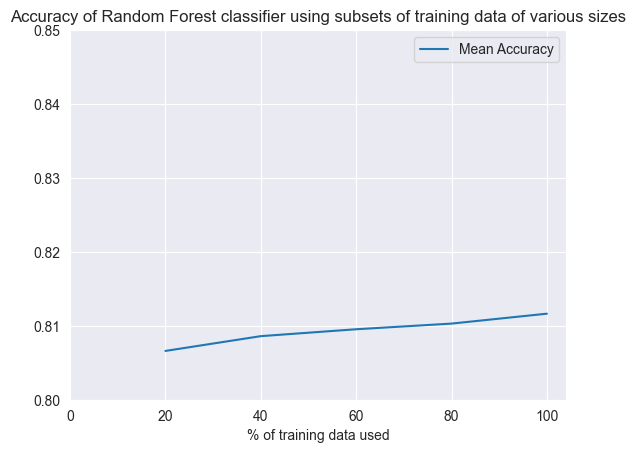

In [32]:
percentages = np.linspace(100 / num_subsets, 100, num=num_subsets)
plt.plot(percentages, mean_accuracies, label="Mean Accuracy")
plt.xlabel("% of training data used")
plt.xlim(left=0)
plt.ylim(bottom=0.8, top=0.85)
plt.title("Accuracy of Random Forest classifier using subsets of training data of various sizes")
plt.legend()
plt.show()
# Accuracy does not seem to vary too much - the gain in mean accuracy from using 20% of the data to using 100% of the data is only 0.005. For this reason, we will run GridSearchCV on only 20% of the data to save time while investigating the effect of hyperparameters.

In [34]:
print(std_accuracies)

[0.008428523002282149, 0.00251793566240286, 0.0023532483459630356, 0.004912738543826658, 0.004062314611154597]


In [35]:
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5],
    'bootstrap': [True],
    'criterion': ['gini']
}

In [36]:
# Set up the grid search with cross-validation
rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=5, n_jobs=-1, verbose=2)

In [38]:
# Use the first 20% of the data as discussed above (first 5,000 samples)
rf_grid_search.fit(X_train_vec[:5000], y_train[:5000])

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True], 'criterion': ['gini'],
                         'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 5],
                         'min_samples_split': [2, 10],
                         'n_estimators': [100, 200]},
             verbose=2)

In [53]:
rf_grid_search.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=200,
                       random_state=42)

In [42]:
rf_grid_search.cv_results_

{'mean_fit_time': array([ 5.24070606, 10.41813316,  5.04426146, 10.21663995,  4.38319726,
         8.80651722,  4.2539331 ,  8.78598986,  4.39610906,  8.72044392,
         4.2690486 ,  8.59784031,  3.97553639,  8.08888326,  3.95311737,
         8.32393703,  5.13114367, 10.15985913,  5.07035074,  9.89749942,
         4.29918523,  8.3911272 ,  4.24730287,  6.80360823]),
 'std_fit_time': array([0.06953078, 0.26937798, 0.16065215, 0.21761795, 0.09666924,
        0.34402669, 0.17178162, 0.24048523, 0.0488154 , 0.26982686,
        0.07801862, 0.22645864, 0.06825844, 0.30547296, 0.09046217,
        0.20190245, 0.13483546, 0.36695792, 0.26886518, 0.1325676 ,
        0.12108781, 0.22822152, 0.10160006, 0.15483651]),
 'mean_score_time': array([0.01960244, 0.03225307, 0.01620641, 0.03300962, 0.01506476,
        0.02914801, 0.0140409 , 0.0276135 , 0.01505618, 0.02583146,
        0.01760559, 0.02288985, 0.01393504, 0.03162885, 0.0129076 ,
        0.0224504 , 0.01409898, 0.03050423, 0.0131249 , 0.03

Text(0.5, 0, 'Model Number')

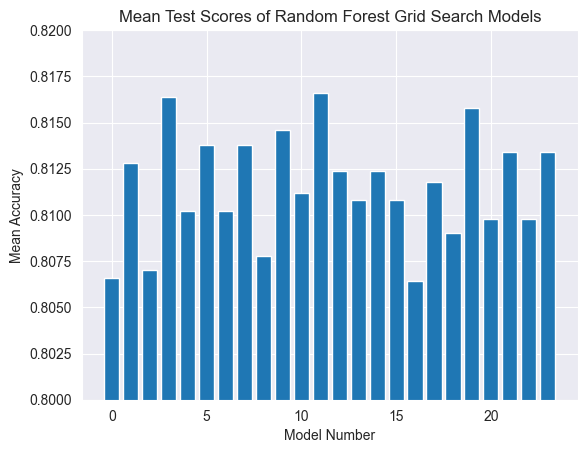

In [214]:
plt.bar(np.arange(24), rf_grid_search.cv_results_["mean_test_score"])
plt.ylim(bottom=0.8, top=0.82)
plt.title("Mean Test Scores of Random Forest Grid Search Models")
plt.ylabel("Mean Accuracy")
plt.xlabel("Model Number")

In [59]:
# Indices 3, 11, and 19 seem to have the highest performance. We print their parameters since we can't neatly plot them on a 2D heatmap like we did for SVM.
print(rf_grid_search.cv_results_["params"][3])
print(rf_grid_search.cv_results_["params"][11])
print(rf_grid_search.cv_results_["params"][19])
# It appears that 1 min_samples_leaf, 10 min_samples_split, and 200 n_estimators performed the best, with the max_depth choice (None, 10, or 20) making a difference, but not as much.

{'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


In [54]:
rf_grid_search.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 200}

In [60]:
rf_param_grid2 = {
    'n_estimators': [200, 300, 400],  # Expanding around the best value
    'max_depth': [10],                # Keeping at 10 since it seemed to have a less significant effect than the other hyperparameters
    'min_samples_split': [8, 10, 12],  # Exploring around the best value we found
    'min_samples_leaf': [1, 2, 3],     # Since 1 worked best, we look at small increments above it
    'bootstrap': [True],               # Keeping it constant since it seems to work well
    'criterion': ['gini']              # Keeping it constant as it's less likely to be as sensitive as others
}

In [61]:
# Set up the grid search with cross-validation
rf_grid_search2 = GridSearchCV(estimator=rf, param_grid=rf_param_grid2, cv=5, n_jobs=-1, verbose=2)
# Use the first 20% of the data as discussed above (first 5,000 samples)
rf_grid_search2.fit(X_train_vec[:5000], y_train[:5000])

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True], 'criterion': ['gini'],
                         'max_depth': [10], 'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [200, 300, 400]},
             verbose=2)

In [63]:
rf_grid_search2.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=300,
                       random_state=42)

In [64]:
rf_grid_search2.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 300}

Text(0.5, 0, 'Model Number')

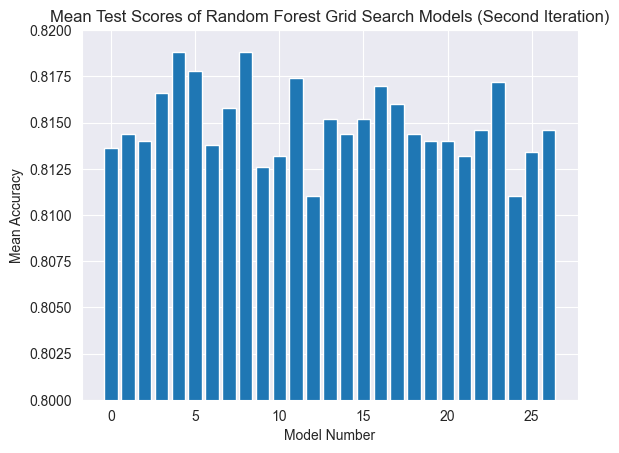

In [215]:
plt.bar(np.arange(27), rf_grid_search2.cv_results_["mean_test_score"])
plt.ylim(bottom=0.8, top=0.82)
plt.title("Mean Test Scores of Random Forest Grid Search Models (Second Iteration)")
plt.ylabel("Mean Accuracy")
plt.xlabel("Model Number")

In [70]:
# Indices 4, 5, and 8 seem to have the highest performance. We print their parameters since we can't neatly plot them on a 2D heatmap like we did for SVM.
print(rf_grid_search2.cv_results_["params"][4])
print(rf_grid_search2.cv_results_["params"][5])
print(rf_grid_search2.cv_results_["params"][8])
# It appears that 1 min_samples_leaf, 10-12 min_samples_split, and 300-400 n_estimators performed the best.

# 12 min_samples_split with 300 estimators didn't seem to perform quite as well
print(rf_grid_search2.cv_results_["params"][7])

# Even though this grid search was only run on the first 5,000 samples of data, it's clear at this point that the random forest classifier is not achieving as good performance as the SVM or even the logistic regression model - those achieved accuracies of at least 0.85, whereas even with the best parameters, this model does not seem likely to go much above 0.82 based on the preceding model runs.

{'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 400}
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 400}
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 300}


In [73]:
# Going back to SVM to see if we can further tune the parameters

svm_param_grid2 = {'C': [2, 10, 50],
              'gamma': [0.2, 1, 5]}

svm_grid2 = GridSearchCV(svm.SVC(), svm_param_grid2, refit=False, verbose=2, n_jobs=-1, cv=5)

svm_grid2.fit(X_train_vec[:5000], y_train[:5000])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [2, 10, 50], 'gamma': [0.2, 1, 5]}, refit=False,
             verbose=2)

In [75]:
# Print best parameters after tuning
print(svm_grid2.best_params_)

{'C': 2, 'gamma': 1}


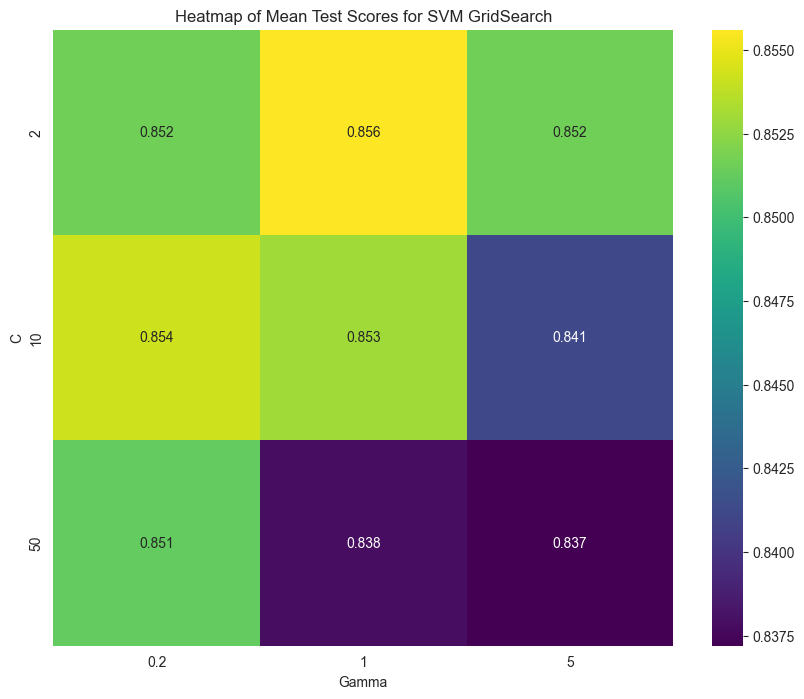

In [77]:
# Extract the scores into a matrix format
C_values2 = [2, 10, 50]
gamma_values2 = [0.2, 1, 5]
svm_cv_scores2 = svm_grid2.cv_results_['mean_test_score'].reshape(len(C_values2), len(gamma_values2))

# Plot scores
plt.figure(figsize=(10, 8))
sns.heatmap(svm_cv_scores2, annot=True, fmt=".3f", cmap='viridis', xticklabels=gamma_values2, yticklabels=C_values2)
plt.title('Heatmap of Mean Test Scores for SVM GridSearch')
plt.xlabel('Gamma')
plt.ylabel('C')
plt.show()

In [83]:
stds = svm_grid2.cv_results_["std_test_score"]
print(stds)
print(np.max(stds))

# The standard deviation is more than half as large as the range of the means, so this grid doesn't tell us definitively which of these parameters are the best. However, one thing it does tell us is that further tweaking of these parameters is unlikely to yield big differences in performance (assuming all other factors remain the same). I created this parameter grid around the best parameters from the initial run of GridSearchCV, with C=10 and gamma=1 at the center and smaller variations in parameters around the edges. Therefore, we'll stick with C=10 and gamma=1 for now.

[0.00801499 0.00621611 0.00924338 0.00915205 0.01067708 0.01352627
 0.00897552 0.01010742 0.01362938]
0.013629380029920668


In [99]:
# We investigate using a neural network model for better performance.
X_train_preprocessed = [preprocess(text) for text in X_train]
X_test_preprocessed = [preprocess(text) for text in X_test]

241.0


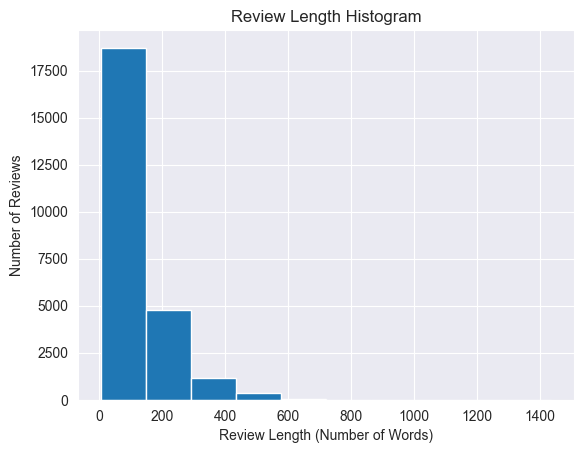

In [216]:
text_lengths = [len(text) for text in X_train_preprocessed]
plt.hist(text_lengths)

plt.title("Review Length Histogram")
plt.xlabel("Review Length (Number of Words)")
plt.ylabel("Number of Reviews")

print(np.percentile(text_lengths, 90))


# The 90th percentile review in the training dataset is 241 words long. We pad/truncate all reviews to be 250 words in length, just to choose a more round number.

In [102]:
max_length = 250

words = set()

for document in X_train_preprocessed:
    words.update([word for word in document if word in model.key_to_index])

words_sorted = sorted(words)
words_sorted.append("<UNK>")
# Don't use 0 as a valid word since we're going to pad the sequences
word_to_idx = {word: i + 1 for i, word in enumerate(words_sorted)}

print(len(words_sorted))
print(len(word_to_idx))

43281
43281


In [136]:
num_words = 40000  # Using the 40,000 most common words

In [137]:
# Tokenizing the texts
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train_preprocessed)

# Convert text to sequence of integers
X_train_sequences = tokenizer.texts_to_sequences(X_train_preprocessed)
X_test_sequences = tokenizer.texts_to_sequences(X_test_preprocessed)

# Pad sequences to ensure uniform length
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding="post", truncating="post")
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding="post", truncating="post")

# Convert labels to NumPy array
y_train_np = np.array(y_train)
y_test_np = np.array(y_test)

In [138]:
X_train_padded

array([[ 153,  484,  241, ...,    0,    0,    0],
       [  14,   34,    1, ...,    0,    0,    0],
       [  33,   18,  597, ...,    0,    0,    0],
       ...,
       [ 289,    1,  289, ...,    0,    0,    0],
       [2473,   94, 6694, ...,    0,    0,    0],
       [ 496,  809,  888, ...,    0,    0,    0]], dtype=int32)

In [139]:
X_test_padded

array([[  344,    22,  8192, ...,     0,     0,     0],
       [  993,   154,  3014, ...,     0,     0,     0],
       [  637, 11222, 11371, ...,     0,     0,     0],
       ...,
       [   29,     1,   864, ...,     0,     0,     0],
       [  580,   100,    86, ...,     0,     0,     0],
       [   13,  1702,  1984, ...,     0,     0,     0]], dtype=int32)

In [140]:
model = Sequential()
model.add(Embedding(num_words, 32, input_length=max_length))  # Embedding layer
model.add(Flatten())  # Flatten the output
model.add(Dense(256, activation='relu'))  # Dense layer with 256 units
model.add(Dropout(0.5))  # Dropout for regularization
model.add(Dense(1, activation='sigmoid'))  # Output layer

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [218]:
history = model.fit(X_train_padded, y_train_np, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 3s 5ms/step - loss: 1.5155e-05 - accuracy: 1.0000 - val_loss: 0.7324 - val_accuracy: 0.8642
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 1.0884e-05 - accuracy: 1.0000 - val_loss: 0.7494 - val_accuracy: 0.8654
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 7.7055e-06 - accuracy: 1.0000 - val_loss: 0.7911 - val_accuracy: 0.8616
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 5.6452e-06 - accuracy: 1.0000 - val_loss: 0.7902 - val_accuracy: 0.8644
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 4.1427e-06 - accuracy: 1.0000 - val_loss: 0.8148 - val_accuracy: 0.8650
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 2.7004e-06 - accuracy: 1.0000 - val_loss: 0.8364 - val_accuracy: 0.8650
Epoch 7/10
625/625 [==============================] - 3s 5ms/step - loss: 1.7095e-06 - accuracy: 1.0000 - val_loss: 0.8564 -

In [219]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

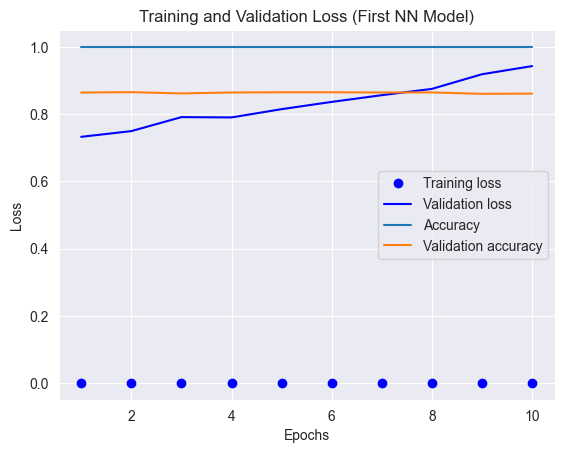

In [220]:
# Plot training and validation loss and accuracy
plt.plot(epochs, train_loss, 'bo', label='Training loss')  # Blue color and dot markers
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # Solid blue line
plt.plot(epochs, history.history["accuracy"], label="Accuracy")
plt.plot(epochs, history.history["val_accuracy"], label="Validation accuracy")
plt.title('Training and Validation Loss (First NN Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [149]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)  # Stop after 3 epochs with no improvement

model2 = Sequential()
model2.add(Embedding(num_words, 32, input_length=max_length))  # Embedding layer
model2.add(Flatten())  # Flatten the output
model2.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))  # Add regularization to the dense layer to penalize large weights, and use fewer neurons to reduce complexity
model2.add(Dropout(0.6))  # Increase dropout
model2.add(Dense(1, activation='sigmoid'))  # Output layer

adam = Adam(learning_rate=0.001)  # Start with a smaller learning rate
model2.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [150]:
history2 = model2.fit(X_train_padded, y_train_np, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping], shuffle=True)

Epoch 1/10
625/625 [==============================] - 4s 7ms/step - loss: 0.6194 - accuracy: 0.7775 - val_loss: 0.4854 - val_accuracy: 0.8652
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3897 - accuracy: 0.9131 - val_loss: 0.4851 - val_accuracy: 0.8784
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 0.2937 - accuracy: 0.9516 - val_loss: 0.4807 - val_accuracy: 0.8714
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.2172 - accuracy: 0.9753 - val_loss: 0.5201 - val_accuracy: 0.8666
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.1698 - accuracy: 0.9870 - val_loss: 0.5332 - val_accuracy: 0.8688
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 0.1481 - accuracy: 0.9913 - val_loss: 0.5466 - val_accuracy: 0.8610


In [157]:
train_loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epochs2 = range(1, len(train_loss2) + 1)

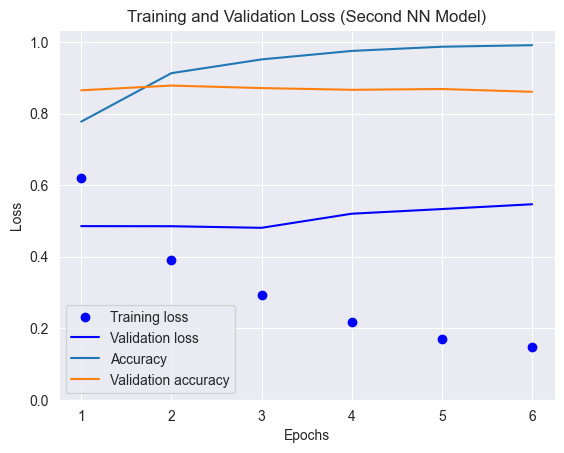

In [221]:
# Plot training and validation loss and accuracy
plt.plot(epochs2, train_loss2, 'bo', label='Training loss')  # Blue color and dot markers
plt.plot(epochs2, val_loss2, 'b', label='Validation loss')  # Solid blue line
plt.plot(epochs2, history2.history["accuracy"], label="Accuracy")
plt.plot(epochs2, history2.history["val_accuracy"], label="Validation accuracy")
plt.title('Training and Validation Loss (Second NN Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(bottom=0)
plt.legend()
plt.show()

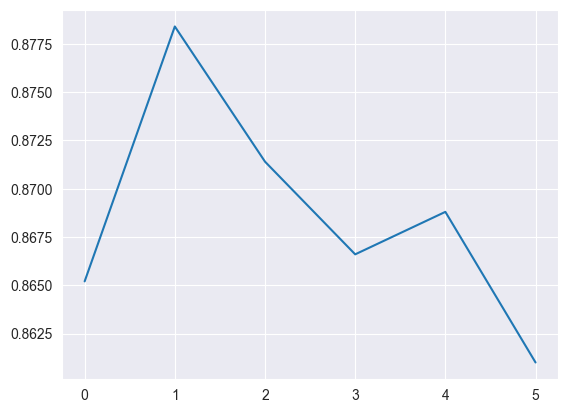

In [164]:
plt.plot(history2.history["val_accuracy"])

In [181]:
def create_model():
    nn_model = Sequential()
    nn_model.add(Embedding(num_words, 32, input_length=max_length))
    nn_model.add(Flatten())
    nn_model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    nn_model.add(Dropout(0.6))
    nn_model.add(Dense(1, activation='sigmoid'))
    # adam = Adam(learning_rate=0.001)
    nn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return nn_model

nn_model_classifier = KerasClassifier(build_fn=create_model, epochs=2, batch_size=32, verbose=2, shuffle=True)  # Reduce to 2 epochs since the model seems to overfit after that
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Retains approximate 50/50 class distribution within each fold

In [182]:
# Perform cross-validation
cv_scores = cross_val_score(nn_model_classifier, X_train_padded, y_train_np, cv=kfold)

Epoch 1/2


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


625/625 - 3s - loss: 0.6351 - accuracy: 0.7627 - 3s/epoch - 6ms/step
Epoch 2/2
625/625 - 3s - loss: 0.4013 - accuracy: 0.9124 - 3s/epoch - 5ms/step
157/157 - 0s - 118ms/epoch - 749us/step
Epoch 1/2


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


625/625 - 3s - loss: 0.6375 - accuracy: 0.7503 - 3s/epoch - 5ms/step
Epoch 2/2
625/625 - 3s - loss: 0.3955 - accuracy: 0.9093 - 3s/epoch - 5ms/step
157/157 - 0s - 121ms/epoch - 768us/step
Epoch 1/2


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


625/625 - 3s - loss: 0.6299 - accuracy: 0.7693 - 3s/epoch - 6ms/step
Epoch 2/2
625/625 - 3s - loss: 0.3927 - accuracy: 0.9118 - 3s/epoch - 5ms/step
157/157 - 0s - 118ms/epoch - 754us/step
Epoch 1/2


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


625/625 - 3s - loss: 0.6242 - accuracy: 0.7660 - 3s/epoch - 5ms/step
Epoch 2/2
625/625 - 3s - loss: 0.3938 - accuracy: 0.9148 - 3s/epoch - 5ms/step
157/157 - 0s - 126ms/epoch - 804us/step
Epoch 1/2


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


625/625 - 3s - loss: 0.6310 - accuracy: 0.7746 - 3s/epoch - 5ms/step
Epoch 2/2
625/625 - 3s - loss: 0.4023 - accuracy: 0.9121 - 3s/epoch - 5ms/step
157/157 - 0s - 123ms/epoch - 783us/step


In [183]:
cv_scores

array([0.8866, 0.8764, 0.8822, 0.8802, 0.8796])

In [184]:
# This is the best performance of all the models so far, so we train it on the full train dataset and analyze it on the test dataset.
np.mean(cv_scores)

0.881

In [185]:
np.std(cv_scores)

0.003363331681532491

In [187]:
final_model = create_model()
final_model.fit(X_train_padded, y_train, epochs=2, batch_size=32, verbose=2, shuffle=True)

Epoch 1/2
782/782 - 5s - loss: 0.5992 - accuracy: 0.7832 - 5s/epoch - 6ms/step
Epoch 2/2
782/782 - 4s - loss: 0.3824 - accuracy: 0.9141 - 4s/epoch - 5ms/step


In [205]:
# Make predictions
predictions = final_model.predict(X_test_padded)
binary_predictions = (predictions > 0.5).astype("int32")

782/782 [==============================] - 1s 729us/step


In [206]:
binary_predictions

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int32)

In [207]:
accuracy = np.mean(binary_predictions.flatten() == y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8622


In [208]:
report = classification_report(y_test, binary_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.87      0.86     12500
           1       0.87      0.86      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



In [213]:
# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions)
print(conf_matrix)

[[10865  1635]
 [ 1810 10690]]
